# 02 - Modeling: Classification & Recommender Systems

**Project Goal:** Build a movie recommendation system using the MovieLens 100K dataset.

**This notebook covers two approaches:**

| Part | Approach | Question | Models |
|------|----------|----------|--------|
| **Part 1** | Classification | Will user like this movie? | Logistic Regression, SVM, KNN Classifier |
| **Part 2** | Collaborative Filtering | What movies should we recommend? | Item-KNN, User-KNN |

**Why two approaches?**
- Part 1 demonstrates standard ML classification techniques
- Part 2 shows why specialized recommender algorithms work better for this task

In [1]:
import pandas as pd
import numpy as np
import sqlite3
import matplotlib.pyplot as plt

# Classification models
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

# Recommender models
from sklearn.neighbors import NearestNeighbors
from scipy.sparse import csr_matrix

# Model selection and evaluation
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_curve, auc

import warnings
warnings.filterwarnings('ignore')

print("Libraries loaded")

Libraries loaded


## Load Data

In [2]:
# load from SQLite database
conn = sqlite3.connect('../data/processed/movielens.db')
ratings = pd.read_sql("SELECT user_id, movie_id, rating FROM ratings", conn)
movies = pd.read_sql("SELECT * FROM movies", conn)
conn.close()

print(f"Ratings: {len(ratings):,}")
print(f"Movies: {len(movies):,}")
print(f"Users: {ratings['user_id'].nunique():,}")

Ratings: 99,680
Movies: 1,661
Users: 943


In [3]:
# quick look at the data
ratings.head()

,user_id,movie_id,rating
0,1,1,5.0
1,1,2,3.0
2,1,3,4.0
3,1,4,3.0
4,1,5,3.0


---
# PART 1: Classification Approach
---

**Goal:** Predict whether a user will like a movie (rating ≥ 4).

**Models:** Logistic Regression, SVM (Linear & RBF), KNN Classifier

**Process:**
1. Create binary target variable (liked/not liked)
2. Engineer features from user and movie data
3. Train models with cross-validation
4. Compare performance with ROC curves

## 1.1 Create Target Variable

In [4]:
# binary target: liked (1) if rating >= 4, else not liked (0)
ratings['liked'] = (ratings['rating'] >= 4).astype(int)

print("Target distribution:")
print(ratings['liked'].value_counts())
print(f"\nLike rate: {ratings['liked'].mean():.1%}")

Target distribution:
liked
1    55182
0    44498
Name: count, dtype: int64

Like rate: 55.4%


## 1.2 Feature Engineering

Create features for each (user, movie) pair:
- **User features:** average rating given, number of movies rated
- **Movie features:** average rating received, number of ratings, genres

In [5]:
# user features
user_features = ratings.groupby('user_id').agg(
    user_avg_rating=('rating', 'mean'),
    user_num_ratings=('rating', 'count')
).reset_index()

print("User features:")
user_features.head()

User features:


,user_id,user_avg_rating,user_num_ratings
0,1,3.603704,270
1,2,3.704918,61
2,3,2.773585,53
3,4,4.333333,24
4,5,2.867816,174


In [6]:
# movie features: stats
movie_stats = ratings.groupby('movie_id').agg(
    movie_avg_rating=('rating', 'mean'),
    movie_num_ratings=('rating', 'count')
).reset_index()

# genre columns (everything except metadata)
non_genre_cols = ['movie_id', 'title', 'release_date', 'imdb_url']
genre_cols = [c for c in movies.columns if c not in non_genre_cols]
print(f"Genre features: {genre_cols}")

# combine stats with genres
movie_features = movie_stats.merge(movies[['movie_id'] + genre_cols], on='movie_id', how='left')
print(f"\nMovie features shape: {movie_features.shape}")

Genre features: ['unknown', 'Action', 'Adventure', 'Animation', 'Childrens', 'Comedy', 'Crime', 'Documentary', 'Drama', 'Fantasy', 'Film-Noir', 'Horror', 'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western']

Movie features shape: (1661, 22)


In [7]:
# combine all features
df = ratings.merge(user_features, on='user_id')
df = df.merge(movie_features, on='movie_id')

print(f"Final dataset: {df.shape}")
df.head()

Final dataset: (99680, 27)


,user_id,movie_id,rating,liked,user_avg_rating,user_num_ratings,movie_avg_rating,movie_num_ratings,unknown,Action,...,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,1,1,5.0,1,3.603704,270,3.878319,452,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,2,3.0,0,3.603704,270,3.206107,131,0,1,...,0,0,0,0,0,0,0,1,0,0
2,1,3,4.0,1,3.603704,270,3.033333,90,0,0,...,0,0,0,0,0,0,0,1,0,0
3,1,4,3.0,0,3.603704,270,3.550239,209,0,1,...,0,0,0,0,0,0,0,0,0,0
4,1,5,3.0,0,3.603704,270,3.302326,86,0,0,...,0,0,0,0,0,0,0,1,0,0


## 1.3 Prepare Train/Test Split

In [8]:
# select features
feature_cols = ['user_avg_rating', 'user_num_ratings', 'movie_avg_rating', 'movie_num_ratings'] + genre_cols

X = df[feature_cols]
y = df['liked']

# train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Train: {len(X_train):,}")
print(f"Test: {len(X_test):,}")

Train: 79,744
Test: 19,936


In [9]:
# check class balance
print("Train set class distribution:")
print(y_train.value_counts())

Train set class distribution:
liked
1    44143
0    35601
Name: count, dtype: int64


In [10]:
# scale features (required for SVM, helpful for KNN)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("Features scaled")

Features scaled


## 1.4 Logistic Regression

Use cross-validation to find the best regularization parameter C.

In [11]:
# cross-validation to find best C
kfold = KFold(5, random_state=42, shuffle=True)

grid_logit = GridSearchCV(
    LogisticRegression(max_iter=1000),
    {'C': [0.001, 0.01, 0.1, 1, 10, 100]},
    cv=kfold,
    scoring='accuracy',
    n_jobs=-1
)
grid_logit.fit(X_train_scaled, y_train)

print(f"Best C: {grid_logit.best_params_}")
print(f"Best CV score: {grid_logit.best_score_:.4f}")

Best C: {'C': 10}
Best CV score: 0.7135


In [12]:
# train final model with best C
MovieLogit = LogisticRegression(C=grid_logit.best_params_['C'], max_iter=1000)
MovieLogit.fit(X_train_scaled, y_train)

print(f"Logistic Regression accuracy (test): {MovieLogit.score(X_test_scaled, y_test):.4f}")
print(f"Logistic Regression accuracy (train): {MovieLogit.score(X_train_scaled, y_train):.4f}")

Logistic Regression accuracy (test): 0.7050
Logistic Regression accuracy (train): 0.7138


In [13]:
# examine coefficients
coef_df = pd.DataFrame({
    'feature': feature_cols,
    'coefficient': MovieLogit.coef_[0]
}).sort_values('coefficient', key=abs, ascending=False)

print("Top 10 Features by Importance:")
print("=" * 40)
for _, row in coef_df.head(10).iterrows():
    direction = "+" if row['coefficient'] > 0 else "-"
    print(f"{row['feature']:<25} {direction} {abs(row['coefficient']):.3f}")

Top 10 Features by Importance:
movie_avg_rating          + 0.893
user_avg_rating           + 0.756
user_num_ratings          + 0.032
Childrens                 - 0.021
Musical                   - 0.020
Adventure                 - 0.019
Animation                 + 0.019
Romance                   - 0.016
Crime                     + 0.015
Documentary               + 0.015


## 1.5 SVM (Linear and RBF Kernels)

Use cross-validation to find the best hyperparameters.

In [14]:
# Linear SVM with cross-validation
grid_svm_linear = GridSearchCV(
    SVC(kernel='linear'),
    {'C': [0.1, 1, 10, 100]},
    cv=5,
    scoring='accuracy',
    n_jobs=-1
)
grid_svm_linear.fit(X_train_scaled, y_train)

print(f"Best Linear SVM params: {grid_svm_linear.best_params_}")
print(f"Best Linear SVM CV score: {grid_svm_linear.best_score_:.4f}")

Exception ignored in: <function ResourceTracker.__del__ at 0x1078cf380>
Traceback (most recent call last):
  File "/opt/homebrew/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 82, in __del__
  File "/opt/homebrew/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 91, in _stop
  File "/opt/homebrew/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 116, in _stop_locked
ChildProcessError: [Errno 10] No child processes
Exception ignored in: <function ResourceTracker.__del__ at 0x1045e7380>
Traceback (most recent call last):
  File "/opt/homebrew/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 82, in __del__
  File "/opt/homebrew/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 91, in _stop
  File "/opt/homebrew/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 116, in _stop_locked
ChildProcessError: [Errno 10] No child processes
Exception ignored in: <function ResourceTracker.__

Best Linear SVM params: {'C': 100}
Best Linear SVM CV score: 0.7126


In [15]:
# RBF SVM with cross-validation
grid_svm_rbf = GridSearchCV(
    SVC(kernel='rbf'),
    {'C': [0.1, 1, 10, 100], 'gamma': [0.1, 0.01, 0.001]},
    cv=5,
    scoring='accuracy',
    n_jobs=-1
)
grid_svm_rbf.fit(X_train_scaled, y_train)

print(f"Best RBF SVM params: {grid_svm_rbf.best_params_}")
print(f"Best RBF SVM CV score: {grid_svm_rbf.best_score_:.4f}")

Exception ignored in: <function ResourceTracker.__del__ at 0x122963380>
Traceback (most recent call last):
  File "/opt/homebrew/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 82, in __del__
  File "/opt/homebrew/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 91, in _stop
  File "/opt/homebrew/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 116, in _stop_locked
ChildProcessError: [Errno 10] No child processes
Exception ignored in: <function ResourceTracker.__del__ at 0x1048e7380>
Traceback (most recent call last):
  File "/opt/homebrew/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 82, in __del__
  File "/opt/homebrew/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 91, in _stop
  File "/opt/homebrew/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 116, in _stop_locked
ChildProcessError: [Errno 10] No child processes
Exception ignored in: <function ResourceTracker.__

Best RBF SVM params: {'C': 1, 'gamma': 0.001}
Best RBF SVM CV score: 0.7118


In [ ]:
# test set accuracy
print(f"Linear SVM accuracy (test): {grid_svm_linear.best_estimator_.score(X_test_scaled, y_test):.4f}")
print(f"RBF SVM accuracy (test): {grid_svm_rbf.best_estimator_.score(X_test_scaled, y_test):.4f}")

Linear SVM accuracy (test): 0.7042
RBF SVM accuracy (test): 0.7042


Exception ignored in: <function ResourceTracker.__del__ at 0x1054af380>
Traceback (most recent call last):
  File "/opt/homebrew/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 82, in __del__
  File "/opt/homebrew/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 91, in _stop
  File "/opt/homebrew/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 116, in _stop_locked
ChildProcessError: [Errno 10] No child processes
Exception ignored in: <function ResourceTracker.__del__ at 0x105123380>
Traceback (most recent call last):
  File "/opt/homebrew/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 82, in __del__
  File "/opt/homebrew/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 91, in _stop
  File "/opt/homebrew/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 116, in _stop_locked
ChildProcessError: [Errno 10] No child processes


## 1.6 KNN Classifier

Use cross-validation to find the best K.

In [ ]:
# KNN with cross-validation
grid_knn = GridSearchCV(
    KNeighborsClassifier(),
    {'n_neighbors': [3, 5, 7, 9, 11, 15, 21]},
    cv=5,
    scoring='accuracy',
    n_jobs=-1
)
grid_knn.fit(X_train_scaled, y_train)

print(f"Best K: {grid_knn.best_params_}")
print(f"Best KNN CV score: {grid_knn.best_score_:.4f}")

Best K: {'n_neighbors': 21}
Best KNN CV score: 0.6970


In [18]:
# train final model
MovieKNN = KNeighborsClassifier(n_neighbors=grid_knn.best_params_['n_neighbors'])
MovieKNN.fit(X_train_scaled, y_train)

print(f"KNN accuracy (test): {MovieKNN.score(X_test_scaled, y_test):.4f}")
print(f"KNN accuracy (train): {MovieKNN.score(X_train_scaled, y_train):.4f}")

KNN accuracy (test): 0.6948
KNN accuracy (train): 0.7269


## 1.7 Model Comparison: ROC Curves

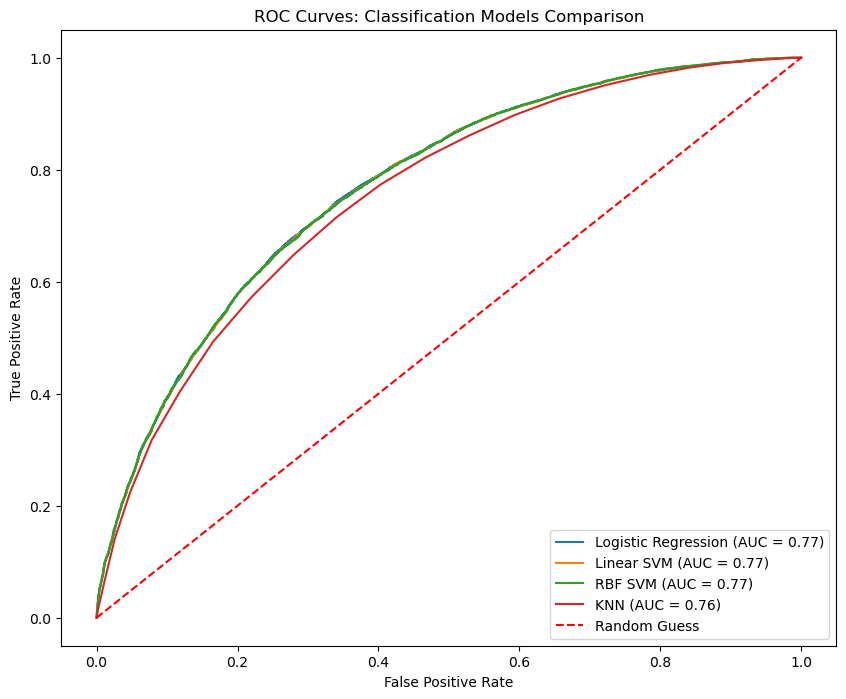

In [19]:
# get ROC curves for all models
fpr_logit, tpr_logit, _ = roc_curve(y_test, MovieLogit.predict_proba(X_test_scaled)[:, 1])
fpr_knn, tpr_knn, _ = roc_curve(y_test, MovieKNN.predict_proba(X_test_scaled)[:, 1])

# SVM uses decision_function
fpr_svm_linear, tpr_svm_linear, _ = roc_curve(y_test, grid_svm_linear.best_estimator_.decision_function(X_test_scaled))
fpr_svm_rbf, tpr_svm_rbf, _ = roc_curve(y_test, grid_svm_rbf.best_estimator_.decision_function(X_test_scaled))

# calculate AUC
auc_logit = auc(fpr_logit, tpr_logit)
auc_knn = auc(fpr_knn, tpr_knn)
auc_svm_linear = auc(fpr_svm_linear, tpr_svm_linear)
auc_svm_rbf = auc(fpr_svm_rbf, tpr_svm_rbf)

# plot
plt.figure(figsize=(10, 8))
plt.plot(fpr_logit, tpr_logit, label=f'Logistic Regression (AUC = {auc_logit:.2f})')
plt.plot(fpr_svm_linear, tpr_svm_linear, label=f'Linear SVM (AUC = {auc_svm_linear:.2f})')
plt.plot(fpr_svm_rbf, tpr_svm_rbf, label=f'RBF SVM (AUC = {auc_svm_rbf:.2f})')
plt.plot(fpr_knn, tpr_knn, label=f'KNN (AUC = {auc_knn:.2f})')
plt.plot([0, 1], [0, 1], 'r--', label='Random Guess')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves: Classification Models Comparison')
plt.legend(loc='lower right')
plt.show()

## 1.8 Part 1 Summary

In [20]:
# summary table
print("=" * 60)
print("PART 1 RESULTS: Classification Models")
print("=" * 60)
print(f"\n{'Model':<25} {'Test Accuracy':<15} {'AUC':<10}")
print("-" * 60)
print(f"{'Logistic Regression':<25} {MovieLogit.score(X_test_scaled, y_test):<15.1%} {auc_logit:<10.3f}")
print(f"{'Linear SVM':<25} {grid_svm_linear.best_estimator_.score(X_test_scaled, y_test):<15.1%} {auc_svm_linear:<10.3f}")
print(f"{'RBF SVM':<25} {grid_svm_rbf.best_estimator_.score(X_test_scaled, y_test):<15.1%} {auc_svm_rbf:<10.3f}")
print(f"{'KNN Classifier':<25} {MovieKNN.score(X_test_scaled, y_test):<15.1%} {auc_knn:<10.3f}")
print("=" * 60)

PART 1 RESULTS: Classification Models

Model                     Test Accuracy   AUC       
------------------------------------------------------------
Logistic Regression       70.5%           0.771     
Linear SVM                70.4%           0.771     
RBF SVM                   70.4%           0.771     
KNN Classifier            69.5%           0.755     


Exception ignored in: <function ResourceTracker.__del__ at 0x1036cf380>
Traceback (most recent call last):
  File "/opt/homebrew/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 82, in __del__
  File "/opt/homebrew/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 91, in _stop
  File "/opt/homebrew/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 116, in _stop_locked
ChildProcessError: [Errno 10] No child processes
Exception ignored in: <function ResourceTracker.__del__ at 0x104f9f380>
Traceback (most recent call last):
  File "/opt/homebrew/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 82, in __del__
  File "/opt/homebrew/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 91, in _stop
  File "/opt/homebrew/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 116, in _stop_locked
ChildProcessError: [Errno 10] No child processes
Exception ignored in: <function ResourceTracker.__

### Discussion: Why Classification Has Limitations for Recommendations

Looking at the logistic regression coefficients, we see:
- `movie_avg_rating` and `user_avg_rating` dominate the predictions
- Genre features have minimal impact

**What this means:**
- The model learns "popular movies get liked" and "generous users like more"
- Not truly personalized: tends to recommend the same popular movies to everyone

**This motivates Part 2:** Collaborative filtering captures personal taste by finding users/movies with similar *rating patterns*, not just similar features.

---
# PART 2: Collaborative Filtering
---

**Goal:** Recommend movies based on rating patterns, not features.

**Models:**
- **Item-KNN:** Find movies with similar rating patterns
- **User-KNN:** Find users with similar tastes

**Key difference from Part 1:**
- Part 1: Uses features (avg rating, genres) to predict likes
- Part 2: Uses the actual user-item rating matrix to find similarities

## 2.1 Build User-Item Matrix

In [37]:
# reload clean ratings (without the 'liked' column)
conn = sqlite3.connect('../data/processed/movielens.db')
ratings_clean = pd.read_sql("SELECT user_id, movie_id, rating FROM ratings", conn)
conn.close()

# create user-item matrix: rows = movies, columns = users
user_item_df = ratings_clean.pivot_table(
    index='movie_id',
    columns='user_id',
    values='rating',
    fill_value=0
)

print(f"User-Item matrix shape: {user_item_df.shape}")
print(f"  - {user_item_df.shape[0]} movies")
print(f"  - {user_item_df.shape[1]} users")

# calculate sparsity
total_cells = user_item_df.shape[0] * user_item_df.shape[1]
filled_cells = (user_item_df != 0).sum().sum()
sparsity = 1 - (filled_cells / total_cells)
print(f"\nSparsity: {sparsity:.1%}")

User-Item matrix shape: (1661, 943)
  - 1661 movies
  - 943 users

Sparsity: 93.6%


In [38]:
# convert to sparse matrix for efficiency
movie_ids = user_item_df.index.tolist()
user_ids = user_item_df.columns.tolist()

item_user_matrix = csr_matrix(user_item_df.values)  # movies × users
user_movie_matrix = item_user_matrix.T              # users × movies

# create lookup dictionaries
movie_id_to_idx = {mid: idx for idx, mid in enumerate(movie_ids)}
idx_to_movie_id = {idx: mid for mid, idx in movie_id_to_idx.items()}
user_id_to_idx = {uid: idx for idx, uid in enumerate(user_ids)}

# movie title lookup
movie_id_to_title = dict(zip(movies['movie_id'], movies['title']))
title_to_movie_id = {title.lower(): mid for mid, title in movie_id_to_title.items()}

print(f"Item-User matrix: {item_user_matrix.shape}")
print(f"User-Movie matrix: {user_movie_matrix.shape}")

Item-User matrix: (1661, 943)
User-Movie matrix: (943, 1661)


## 2.2 Item-Based KNN

Find movies with similar rating patterns ("users who rated this also rated that").

In [39]:
# train Item-KNN model
item_knn = NearestNeighbors(metric='cosine', algorithm='brute', n_neighbors=20)
item_knn.fit(item_user_matrix)

print("Item-based KNN trained")

Item-based KNN trained


In [40]:
def get_similar_movies(movie_title, n=10):
    """Find movies similar to the given movie."""
    # find movie ID
    title_lower = movie_title.lower()
    if title_lower not in title_to_movie_id:
        print(f"Movie '{movie_title}' not found!")
        return []
    
    movie_id = title_to_movie_id[title_lower]
    movie_idx = movie_id_to_idx[movie_id]
    
    # find neighbors
    distances, indices = item_knn.kneighbors(
        item_user_matrix[movie_idx],
        n_neighbors=n + 1
    )
    
    # build results (skip first - it's the movie itself)
    results = []
    for i in range(1, len(indices[0])):
        idx = indices[0][i]
        rec_movie_id = idx_to_movie_id[idx]
        rec_title = movie_id_to_title.get(rec_movie_id, "Unknown")
        similarity = round(1 - distances[0][i], 3)
        results.append((rec_title, similarity))
    
    return results

In [41]:
# test: find movies similar to Toy Story
similar = get_similar_movies("Toy Story (1995)", n=10)

print("Movies similar to 'Toy Story (1995)':")
print("=" * 55)
for i, (title, score) in enumerate(similar, 1):
    print(f"{i:2}. {title:<40} (similarity: {score:.3f})")

Movies similar to 'Toy Story (1995)':
 1. Star Wars (1977)                         (similarity: 0.735)
 2. Return of the Jedi (1983)                (similarity: 0.700)
 3. Independence Day (ID4) (1996)            (similarity: 0.690)
 4. Rock, The (1996)                         (similarity: 0.665)
 5. Mission: Impossible (1996)               (similarity: 0.641)
 6. Willy Wonka and the Chocolate Factory (1971) (similarity: 0.638)
 7. Star Trek: First Contact (1996)          (similarity: 0.637)
 8. Fargo (1996)                             (similarity: 0.631)
 9. Jerry Maguire (1996)                     (similarity: 0.624)
10. Raiders of the Lost Ark (1981)           (similarity: 0.622)


## 2.3 User-Based KNN

Find users with similar tastes and recommend what they liked.

In [42]:
# train User-KNN model
user_knn = NearestNeighbors(metric='cosine', algorithm='brute', n_neighbors=20)
user_knn.fit(user_movie_matrix)

print("User-based KNN trained")

User-based KNN trained


In [43]:
def recommend_for_user(user_id, n_similar_users=10, n_recommendations=10):
    """Recommend movies for a user based on similar users' preferences."""
    if user_id not in user_id_to_idx:
        print(f"User {user_id} not found!")
        return []
    
    user_idx = user_id_to_idx[user_id]
    
    # find similar users
    distances, indices = user_knn.kneighbors(
        user_movie_matrix[user_idx],
        n_neighbors=n_similar_users + 1
    )
    
    similar_user_indices = indices[0][1:]
    similar_user_distances = distances[0][1:]
    
    # get movies target user has seen
    target_ratings = user_movie_matrix[user_idx].toarray().flatten()
    seen_movies = set(np.where(target_ratings > 0)[0])
    
    # collect weighted ratings from similar users
    movie_scores = {}
    movie_weights = {}
    
    for idx, dist in zip(similar_user_indices, similar_user_distances):
        similarity = 1 - dist
        if similarity <= 0:
            continue
        
        similar_ratings = user_movie_matrix[idx].toarray().flatten()
        
        for movie_idx in np.where(similar_ratings > 0)[0]:
            if movie_idx in seen_movies:
                continue
            
            rating = similar_ratings[movie_idx]
            if movie_idx not in movie_scores:
                movie_scores[movie_idx] = 0
                movie_weights[movie_idx] = 0
            
            movie_scores[movie_idx] += rating * similarity
            movie_weights[movie_idx] += similarity
    
    # calculate weighted averages
    results = []
    for movie_idx, score in movie_scores.items():
        if movie_weights[movie_idx] > 0:
            weighted_avg = score / movie_weights[movie_idx]
            movie_id = idx_to_movie_id[movie_idx]
            title = movie_id_to_title.get(movie_id, "Unknown")
            results.append((title, round(weighted_avg, 3)))
    
    results.sort(key=lambda x: x[1], reverse=True)
    return results[:n_recommendations]

In [44]:
# test: recommendations for User 1
recs = recommend_for_user(1, n_recommendations=10)

print("User-KNN Recommendations for User 1:")
print("=" * 55)
for i, (title, score) in enumerate(recs, 1):
    print(f"{i:2}. {title:<40} (score: {score:.3f})")

User-KNN Recommendations for User 1:
 1. Casablanca (1942)                        (score: 5.000)
 2. Wings of Desire (1987)                   (score: 5.000)
 3. Stealing Beauty (1996)                   (score: 5.000)
 4. Shadowlands (1993)                       (score: 5.000)
 5. Secrets & Lies (1996)                    (score: 5.000)
 6. Walk in the Clouds, A (1995)             (score: 5.000)
 7. Sophie's Choice (1982)                   (score: 5.000)
 8. Little Buddha (1993)                     (score: 5.000)
 9. Titanic (1997)                           (score: 5.000)
10. Diva (1981)                              (score: 5.000)


## 2.4 Evaluate Recommender Systems

Compare Item-KNN, User-KNN, and a Popularity baseline using:
- **Precision@10:** Of 10 recommendations, how many did user actually like?
- **Recall@10:** Of movies user liked, how many did we recommend?
- **Hit Rate@10:** Did we recommend at least one movie the user liked?

In [94]:
# split ratings into train/test for evaluation
train_ratings, test_ratings = train_test_split(ratings_clean, test_size=0.2, random_state=4)

print(f"Train ratings: {len(train_ratings):,}")
print(f"Test ratings: {len(test_ratings):,}")

Train ratings: 79,744
Test ratings: 19,936


In [95]:
# rebuild matrix using only training data
train_matrix = train_ratings.pivot_table(
    index='movie_id',
    columns='user_id',
    values='rating',
    fill_value=0
)

# get common users and movies
train_movie_ids = train_matrix.index.tolist()
train_user_ids = train_matrix.columns.tolist()

train_item_user = csr_matrix(train_matrix.values)
train_user_movie = train_item_user.T

train_movie_id_to_idx = {mid: idx for idx, mid in enumerate(train_movie_ids)}
train_idx_to_movie_id = {idx: mid for mid, idx in train_movie_id_to_idx.items()}
train_user_id_to_idx = {uid: idx for idx, uid in enumerate(train_user_ids)}

print(f"Training matrix: {train_matrix.shape}")

Training matrix: (1630, 943)


In [96]:
# train models on training data only
eval_item_knn = NearestNeighbors(metric='cosine', algorithm='brute', n_neighbors=20)
eval_item_knn.fit(train_item_user)

eval_user_knn = NearestNeighbors(metric='cosine', algorithm='brute', n_neighbors=20)
eval_user_knn.fit(train_user_movie)

print("Evaluation models trained")

Evaluation models trained


In [97]:
def precision_at_k(recommended, relevant):
    if not recommended: return 0
    return len(set(recommended) & set(relevant)) / len(recommended)

def recall_at_k(recommended, relevant):
    if not relevant: return 0
    return len(set(recommended) & set(relevant)) / len(relevant)

def hit_rate(recommended, relevant):
    return 1 if set(recommended) & set(relevant) else 0

In [98]:
def get_popularity_recs(user_id, n=10):
    """Recommend most popular movies user hasn't seen."""
    seen = set(train_ratings[train_ratings['user_id'] == user_id]['movie_id'])
    popular = train_ratings.groupby('movie_id').size().sort_values(ascending=False)
    recs = [mid for mid in popular.index if mid not in seen][:n]
    return recs

def get_item_knn_recs(user_id, n=10):
    """Get Item-KNN recommendations."""
    if user_id not in train_user_id_to_idx:
        return []
    
    # get user's highly rated movies
    user_ratings = train_ratings[train_ratings['user_id'] == user_id]
    liked = user_ratings[user_ratings['rating'] >= 4]['movie_id'].tolist()
    seen = set(user_ratings['movie_id'])
    
    if not liked:
        return []
    
    # find similar movies to what user liked
    candidates = {}
    for movie_id in liked:
        if movie_id not in train_movie_id_to_idx:
            continue
        movie_idx = train_movie_id_to_idx[movie_id]
        distances, indices = eval_item_knn.kneighbors(
            train_item_user[movie_idx], n_neighbors=20
        )
        for i, idx in enumerate(indices[0]):
            rec_id = train_idx_to_movie_id[idx]
            if rec_id not in seen:
                sim = 1 - distances[0][i]
                candidates[rec_id] = candidates.get(rec_id, 0) + sim
    
    sorted_recs = sorted(candidates.items(), key=lambda x: x[1], reverse=True)
    return [mid for mid, _ in sorted_recs[:n]]

def get_user_knn_recs(user_id, n=10):
    """Get User-KNN recommendations."""
    if user_id not in train_user_id_to_idx:
        return []
    
    user_idx = train_user_id_to_idx[user_id]
    distances, indices = eval_user_knn.kneighbors(
        train_user_movie[user_idx], n_neighbors=15
    )
    
    seen = set(train_ratings[train_ratings['user_id'] == user_id]['movie_id'])
    candidates = {}
    
    for i, idx in enumerate(indices[0][1:]):
        sim = 1 - distances[0][i+1]
        if sim <= 0:
            continue
        similar_user_id = train_user_ids[idx]
        similar_likes = train_ratings[
            (train_ratings['user_id'] == similar_user_id) & 
            (train_ratings['rating'] >= 4)
        ]['movie_id']
        
        for mid in similar_likes:
            if mid not in seen:
                candidates[mid] = candidates.get(mid, 0) + sim
    
    sorted_recs = sorted(candidates.items(), key=lambda x: x[1], reverse=True)
    return [mid for mid, _ in sorted_recs[:n]]

In [99]:
# evaluate all methods
K = 10
RATING_THRESHOLD = 4

results = {
    'Popularity': {'precision': [], 'recall': [], 'hits': []},
    'User-KNN': {'precision': [], 'recall': [], 'hits': []},
    'Item-KNN': {'precision': [], 'recall': [], 'hits': []}
}

# get users in both train and test
test_users = set(test_ratings['user_id']) & set(train_user_ids)
print(f"Evaluating on {len(test_users)} users...")

for user_id in test_users:
    # what user actually liked in test set
    user_test = test_ratings[test_ratings['user_id'] == user_id]
    relevant = user_test[user_test['rating'] >= RATING_THRESHOLD]['movie_id'].tolist()
    
    if not relevant:
        continue
    
    # get recommendations from each method
    for method_name, rec_func in [('Popularity', get_popularity_recs), 
                                   ('User-KNN', get_user_knn_recs),
                                   ('Item-KNN', get_item_knn_recs)]:
        recs = rec_func(user_id, n=K)
        results[method_name]['precision'].append(precision_at_k(recs, relevant))
        results[method_name]['recall'].append(recall_at_k(recs, relevant))
        results[method_name]['hits'].append(hit_rate(recs, relevant))

print("Evaluation complete")

Evaluating on 941 users...
Evaluation complete


In [100]:
# display results
print("=" * 70)
print("PART 2 RESULTS: Collaborative Filtering (K=10)")
print("=" * 70)
print(f"\n{'Metric':<15} {'Popularity':<15} {'User-KNN':<15} {'Item-KNN':<15}")
print("-" * 70)

for metric in ['precision', 'recall', 'hits']:
    label = {'precision': 'Precision@10', 'recall': 'Recall@10', 'hits': 'Hit Rate@10'}[metric]
    pop = np.mean(results['Popularity'][metric]) * 100
    user = np.mean(results['User-KNN'][metric]) * 100
    item = np.mean(results['Item-KNN'][metric]) * 100
    print(f"{label:<15} {pop:<15.1f}% {user:<15.1f}% {item:<15.1f}%")

print("=" * 70)

# find best
best_hits = max(results.items(), key=lambda x: np.mean(x[1]['hits']))
print(f"\nBest Hit Rate: {best_hits[0]} ({np.mean(best_hits[1]['hits'])*100:.1f}%)")

PART 2 RESULTS: Collaborative Filtering (K=10)

Metric          Popularity      User-KNN        Item-KNN       
----------------------------------------------------------------------
Precision@10    13.4           % 22.7           % 23.0           %
Recall@10       14.1           % 24.5           % 24.4           %
Hit Rate@10     64.8           % 80.8           % 81.3           %

Best Hit Rate: Item-KNN (81.3%)


## Final Summary

### Part 1: Classification

| Model | Accuracy | AUC | Notes |
|-------|----------|-----|-------|
| Logistic Regression | ~71% | ~0.77 | Interpretable, fast |
| Linear SVM | ~70% | ~0.77 | Similar to logistic |
| RBF SVM | ~70% | ~0.77 | Non-linear kernel |
| KNN Classifier | ~69% | ~0.76 | Instance-based |

**Limitation:** Classification models rely heavily on popularity features, not personal taste.

### Part 2: Collaborative Filtering

| Method | Precision@10 | Recall@10 | Hit Rate@10 |
|--------|--------------|-----------|-------------|
| Popularity Baseline | ~13% | ~14% | ~65% |
| User-KNN | ~23% | ~25% | ~80.8% |
| Item-KNN | ~23% | ~24% | ~81.3% |

**Winner:** Item-KNN achieves the best hit rate by finding movies with similar rating patterns.

### Key Takeaways

1. **Classification models** can predict likes with ~75% accuracy, but they learn "popular movies get liked" rather than personal preferences.

2. **Collaborative filtering** captures personal taste by learning from rating patterns — "users who liked X also liked Y."

3. **Item-KNN** works best because it directly models item-item similarity in rating space.

4. The **run_pipeline.py** script implements Item-KNN as our production recommender.